Shapley Values
------------------------
 
We are going to be working with SHAP (SHapley Additive exPlanations). This procedure is derived from game theory and aims to understand (or explain) the output of any machine learning model. In particular we will:


1. Train a simple CNN on the fashion mnist dataset.
2. Compute the Shapley values for examples of each class.
3. Visualize these values and derive information from them.

To learn more about Shapley Values visit the official [SHAP repo](https://github.com/slundberg/shap).

Let's get started!

## Imports

Begin by installing the shap library:



In [1]:
# !pip install shap
# !pip install tensorflow==2.4.3

Now import all necessary dependencies:

In [2]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2023-03-20 00:37:44.676121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 00:37:45.516133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-20 00:37:45.516247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-20 00:37:45.516255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Train a CNN model

We will use the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset. Load it and pre-process the data before feeding it into the model:

In [3]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

For the CNN model we will use a simple architecture composed of a single convolutional and maxpooling layers pair connected to a fully connected layer with 256 units and the output layer with 10 units since there are 10 categories.

Define the model using Keras' [Functional API](https://keras.io/guides/functional_api/):


In [4]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation="relu")(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)

# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

2023-03-20 00:37:46.709564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-20 00:37:46.724923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-20 00:37:46.724975: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-20 00:37:46.726216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

Epoch 1/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.3005 - val_sparse_categorical_accuracy: 0.8891
Epoch 2/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9079 - val_loss: 0.2668 - val_sparse_categorical_accuracy: 0.9003
Epoch 3/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.9089
Epoch 4/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1699 - sparse_categorical_accuracy: 0.9362 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.8991
Epoch 5/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1396 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.2578 - val_sparse_categorical_accuracy: 0.9117


Judging the accuracy metrics looks like the model is overfitting. However, it is achieving a >90% accuracy on the test set so its performance is adequate for the purposes of this lab.

# Explaining the outputs

We know that the model is correctly classifying around 90% of the images in the test set. But how is it doing it? What pixels are being used to determine if an image belongs to a particular class?

To answer these questions we can use SHAP values.

Before doing so, check how each one of the categories looks like:

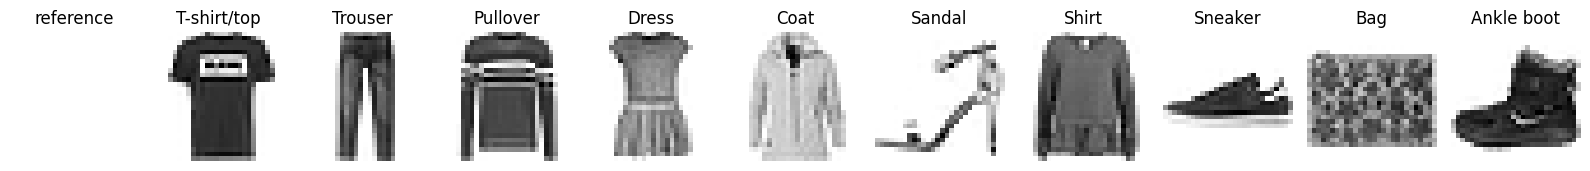

In [5]:
# Name each one of the classes
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
    if len(images_dict) == 10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()

    # Plot an empty canvas
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype="uint8")
    ax.set_title("reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation="nearest")

    # Plot an image for every category
    for k, v in images.items():
        ax = axes[k + 1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"{class_names[k]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


# Use the function to plot
plot_categories(images_dict)

Now we know how the items in each one of the categories looks like.

You might wonder what the empty image at the left is for. We will see shortly why it is important.

## DeepExplainer

To compute shap values for the model you just trained you will use the `DeepExplainer` class from the `shap` library. 

To instantiate this class we need to pass in a model along with training examples. Notice that not all of the training examples are passed in but only a fraction of them. 

This is done because the computations done by the `DeepExplainer` object are very intensive on the RAM and we might run out of it.

In [6]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

# Compute shap values
# shap_values = e.shap_values(x_test[1:5])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2023-03-20 00:40:17.372074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 432640000 exceeds 10% of free system memory.
2023-03-20 00:40:17.758148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 432640000 exceeds 10% of free system memory.
2023-03-20 00:40:17.911190: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 432640000 exceeds 10% of free system memory.


Now we can use the `DeepExplainer` instance to compute Shap values for images on the test set.

So we can properly visualize these values for each class, create an array that contains one element of each class from the test set:

In [7]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict) == 10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


Before computing the shap values, we make sure that the model is able to correctly classify each one of the examples we just picked:

In [8]:
# Compute predictions
predictions = model.predict(x_test_each_class)

# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 71ms/step


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Since the test examples are ordered according to the class number and the predictions array is also ordered, the model was able to correctly classify each one of these images.

## Visualizing Shap Values

Now that we have an example of each class, compute the Shap values for each example:

In [9]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2023-03-20 00:40:19.236768: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 432640000 exceeds 10% of free system memory.
2023-03-20 00:40:19.543665: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 432640000 exceeds 10% of free system memory.


Now take a look at the computed shap values. To understand the next illustration have these points in mind:
- Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.
- Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.
- Each row contains each one of the test images we computed the shap values for.
- Each column represents the ordered categories that the model could choose from. Notice that `shap.image_plot` just makes a copy of the classified image, but we can use the `plot_categories` function we created earlier to show an example of that class for reference.

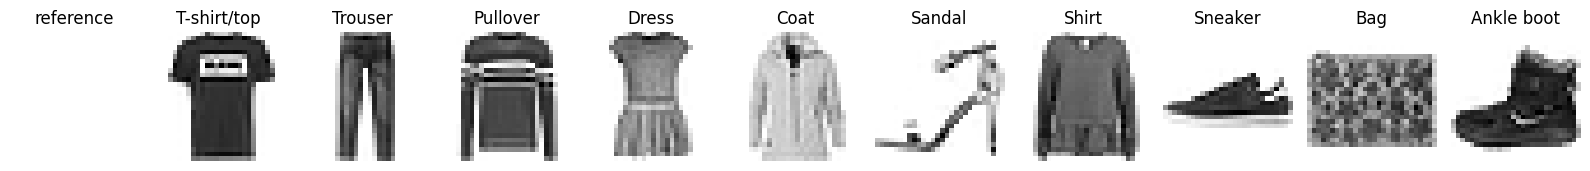

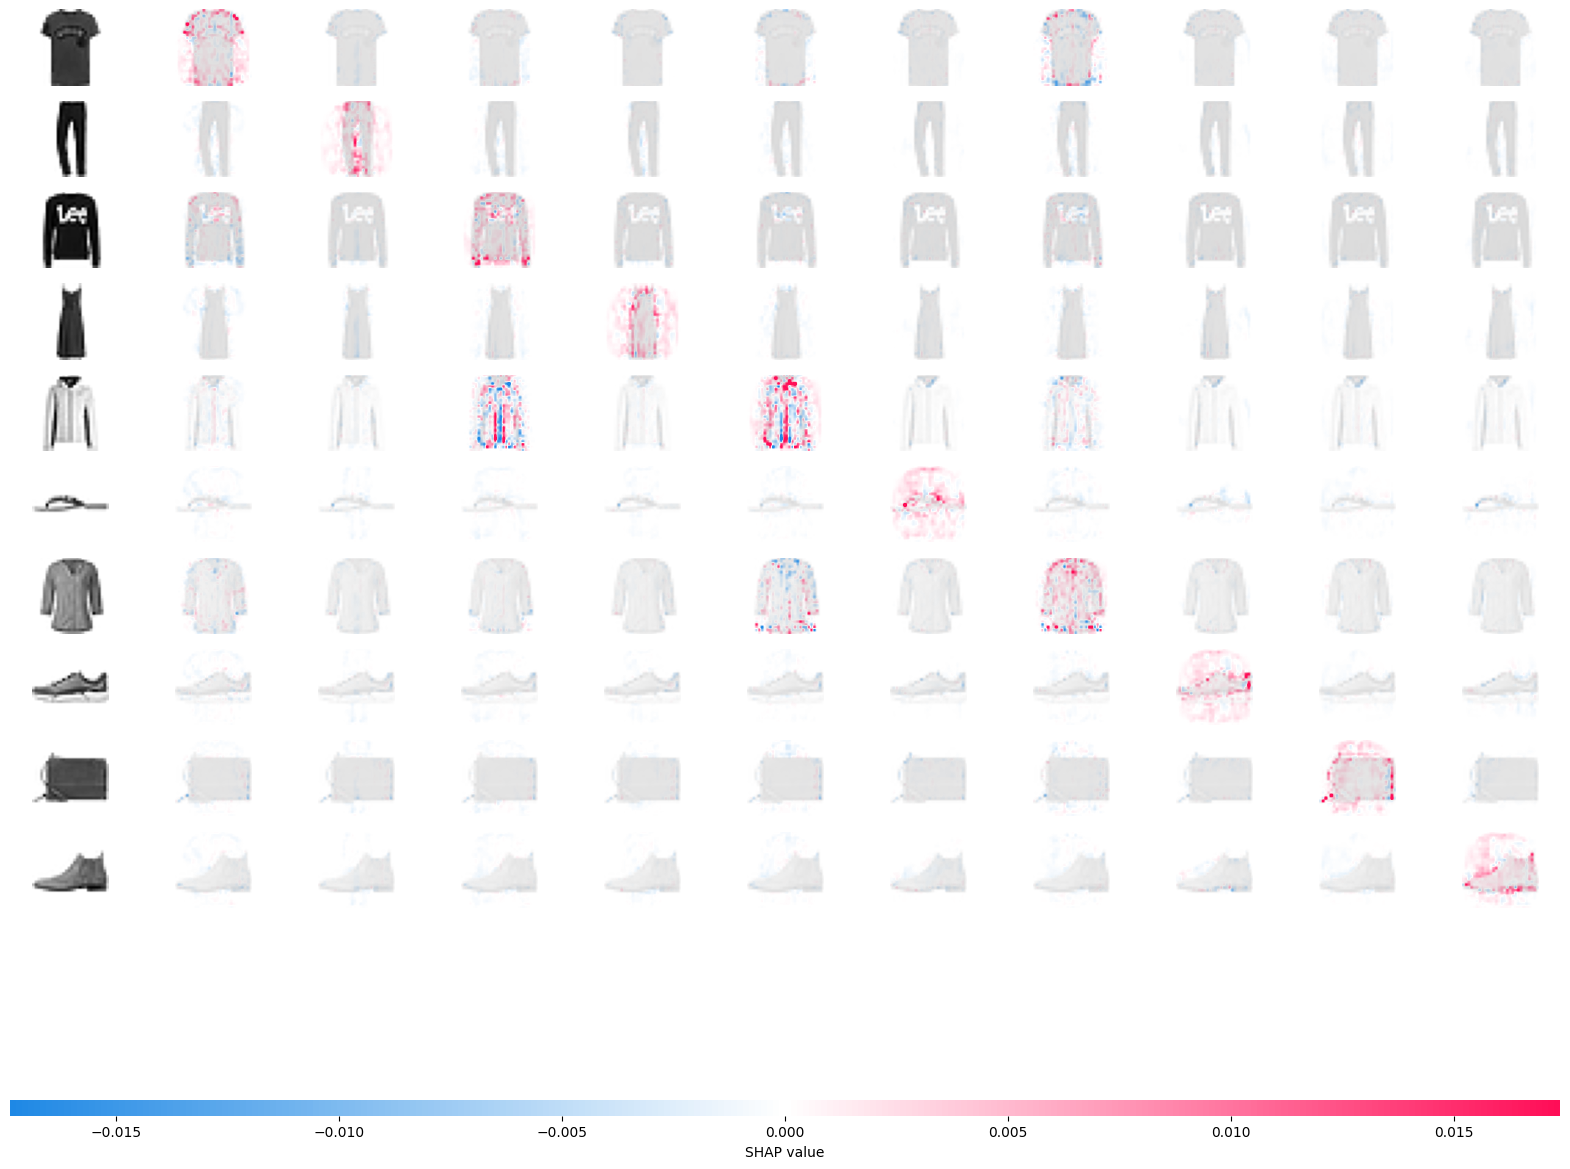

In [10]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

Now take some time to understand what the plot is showing. Since the model is able to correctly classify each one of these 10 images, it makes sense that the shapley values along the diagonal are the most prevalent. Specially positive values since that is the class the model (correctly) predicted.


What else can you derive from this plot? Try focusing on one example. For instance focus on the **coat** which is the fifth class. Looks like the model also had "reasons" to classify it as **pullover** or a **shirt**. This can be concluded from the presence of positive shap values for these clases.

Let's take a look at the tensor of predictions to double check if this was the case:

In [11]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
    print(class_names[i])

Coat
Pullover
Shirt


Indeed the model selected these 3 classes as the most probable ones for the **coat** image. This makes sense since these objects are similar to each other.


Now look at the **t-shirt** which is the first class. This object is very similar to the **pullover** but without the long sleeves. It is not a surprise that white pixels in the area where the long sleeves are present will yield high shap values for classifying as a **t-shirt**. In the same way, white pixels in this area will yield negative shap values for classifying as a **pullover** since the model will expect these pixels to be colored if the item was indeed a **pullover**.


You can get a lot of insight repeating this process for all the classes.

Deep Learning models were considered black boxes for a very long time. There is a natural trade off between predicting power and explanaibility in Machine Learning but thanks to the rise of new techniques such as SHapley Additive exPlanations it is easier than never before to explain the outputs of Deep Learning models.